In [ ]:
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 20.7 µs


In [ ]:
!pip install google-play-scraper
from google_play_scraper import app, Sort, reviews_all
!pip install matplotlib --upgrade
!pip install swifter
!pip install Sastrawi
!pip install googletrans==3.1.0a0
from googletrans import Translator

In [ ]:
import pandas as pd
import numpy as np

from IPython.display import display

# Explore
import matplotlib.pyplot as plt

# Modify
import regex as re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import swifter
import ast

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Model
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Asess
import seaborn as sns
import pickle

import wordcloud
from wordcloud import STOPWORDS
from wordcloud import WordCloud
import PIL
from PIL import Image

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#SAMPLE
*do not run this part again if you already get the data because the result will be different*

##### Scraping Data


In [ ]:
def get_data(app_id):
    result = reviews_all(
        app_id,
        sleep_milliseconds=0,
        lang='id',
        sort=Sort.NEWEST
    )
    return result

In [ ]:
app_ids = [
    'com.adakami.dana.kredit.pinjaman',
    'com.fintopia.idnEasycash.google',
    'com.kreditpintar'
    ]
app_names = ['AdaKami','EasyCash','Kredit Pintar']
app_dfs = []

In [ ]:
for id,name in zip(app_ids, app_names):
    tmp_result = get_data(id)
    tmp_df = pd.DataFrame(np.array(tmp_result), columns=['review'])
    tmp_df = tmp_df.join(pd.DataFrame(tmp_df.pop('review').tolist()))
    tmp_df['appName'] = name

    app_dfs.append(tmp_df)

In [ ]:
for app_df in app_dfs:
    display(app_df)

In [ ]:
for df, name in zip(app_dfs, app_names):
  df.to_excel('datasets/populationData-{}.xlsx'.format(name), index=False)

###### If want to read population data files

In [ ]:
#Additional 1
reads=[
    'populationData-AdaKami.xlsx',
    'populationData-EasyCash.xlsx',
    'populationData-Kredit Pintar.xlsx'
    ]

In [ ]:
#Additional 2
for data in reads:
    df_all = pd.read_excel('datasets/'+data)
    app_dfs.append(df_all)

#####Implementing Random Sampling

In [ ]:
samples = [1000, 1000, 1000] # -/+ 4% moe (cochran calculation)

[1000, 1000, 1000]


In [ ]:
# Get sample data randomly according to sample size
for i, j, k in zip(app_dfs, samples, app_names):
    # Implementing random sampling
    df_sample = i.sample(j,replace=False)
    # Save sample data
    df_sample.to_excel(
        'datasets/sampleData-{}.xlsx'.format(k),
        index=False
    )

##### Read Sample Data Manual Labeled

In [ ]:
#Read file
files = ['AdaKami.xlsx','EasyCash.xlsx','Kredit Pintar.xlsx']

In [ ]:
df_samples = []
for i,j in zip(files,app_names):
    df_sample = pd.read_excel('datasets/'+i,
                              dtype={"mnl_label": int,
                                     "score": int,
                                     "thumbsUpCount":int}
                              )
    df_samples.append(df_sample)
    display(df_sample)

#####Lexicon-based Labelling

In [ ]:
sia = SIA()

In [ ]:
# Analiza sentiment NLTK Vader
def sentiment_analyze(content):
    # translate to english
    translator = Translator()
    translated = translator.translate(content,src='id',dest='en')
    # calculate polarity scores and compound
    score = sia.polarity_scores(translated.text)
    neg = score['neg']
    pos = score['pos']
    neu = score['neu']

    return sia.polarity_scores(translated.text)

In [ ]:
for df_sample, appnm in zip(df_samples,app_names):
    df_sample.insert(4,'polarity', df_sample['content'].apply(
        sentiment_analyze)
    )
    df_sample.insert(5,'compound', df_sample['polarity'].apply(
        lambda d:d['compound'])
    )
    df_sample.insert(6,'lex_label', df_sample['compound'].apply(
        lambda score: 1 if score>=0.05 else 0 if score<=-0.05 else 2)
    )
    # Save sample data
    df_sample.to_excel(
        'datasets/labeledData-{}.xlsx'.format(appnm),
        index=False
    )
    display(df_sample)

#EXPLORE

In [ ]:
#Read file
files = ['labeledData-AdaKami.xlsx','labeledData-EasyCash.xlsx','labeledData-Kredit Pintar.xlsx']
appNames = ['AdaKami','EasyCash','Kredit Pintar']

In [ ]:
# Read files and get data info
df_smps = []
for i,j in zip(files,appNames):
    df_smp = pd.read_excel('datasets/'+i, dtype={"lex_label": int, "mnl_label": int, "score": int, "thumbsUpCount":int})
    df_smps.append(df_smp)
    print('\n'+j+'\n')
    print(df_smp.info())
    print('\n========================================================================')


AdaKami

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1000 non-null   object        
 1   userName              1000 non-null   object        
 2   userImage             1000 non-null   object        
 3   content               1000 non-null   object        
 4   polarity              1000 non-null   object        
 5   compound              1000 non-null   float64       
 6   lex_label             1000 non-null   int64         
 7   mnl_label             1000 non-null   int64         
 8   score                 1000 non-null   int64         
 9   thumbsUpCount         1000 non-null   int64         
 10  reviewCreatedVersion  756 non-null    object        
 11  at                    1000 non-null   datetime64[ns]
 12  replyContent          231 non-null    object        
 13  repliedAt

In [ ]:
def visualizingData (labels, y1, y2, y3, Title):
    x = np.arange(len(labels))
    width = 0.28
    fig, ax = plt.subplots(figsize = (10, 9))
    plt.title('\n'+Title+'\n', size=19)
    # plot data in grouped manner of bar type
    app1 = ax.bar(x-0.28, y1, width, color='steelblue')
    app2 = ax.bar(x, y2, width, color='green')
    app3 = ax.bar(x+0.28, y3, width, color='orange')
    ax.set_xticks(x, labels, size=17)
    ax.set_xlabel('Rating\n', size=17)
    ax.legend(['AdaKami', 'EasyCash', 'Kredit Pintar'], prop={'size': 18})
    ax.bar_label(app1, padding=2, size=14)
    ax.bar_label(app2, padding=2, size=14)
    ax.bar_label(app3, padding=2, size=14)

    fig.tight_layout()
    plt.yticks(size=17)
    plt.show()

In [ ]:
def visualizingData (labels, y1, Title):
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize = (10, 9))
    plt.title('\n'+Title+'\n', size=19)
    # plot data in grouped manner of bar type
    app2 = ax.bar(x, y1, color='green')
    ax.set_xticks(x, labels, size=17)
    ax.set_xlabel('\nRating\n', size=17)
    ax.bar_label(app2, padding=2, size=14)

    fig.tight_layout()
    plt.yticks(size=17)
    plt.show()

In [ ]:
def visualizingData (labels, y1, y2, Title):
    x = np.arange(len(labels))
    width = 0.42
    fig, ax = plt.subplots(figsize = (10, 9))
    plt.title('\n'+Title+'\n', size=19)
    # plot data in grouped manner of bar type
    app1 = ax.bar(x-0.21, y1, width, color='orange')
    app2 = ax.bar(x+0.21, y2, width, color='blue')
    ax.set_xticks(x, labels, size=17)
    ax.set_xlabel('\nSentimen\n', size=17)
    ax.legend(['Label Leksikon', 'Label Manual'], prop={'size': 18})
    ax.bar_label(app1, padding=2, size=14)
    ax.bar_label(app2, padding=2, size=14)

    fig.tight_layout()
    plt.yticks(size=17)
    plt.show()

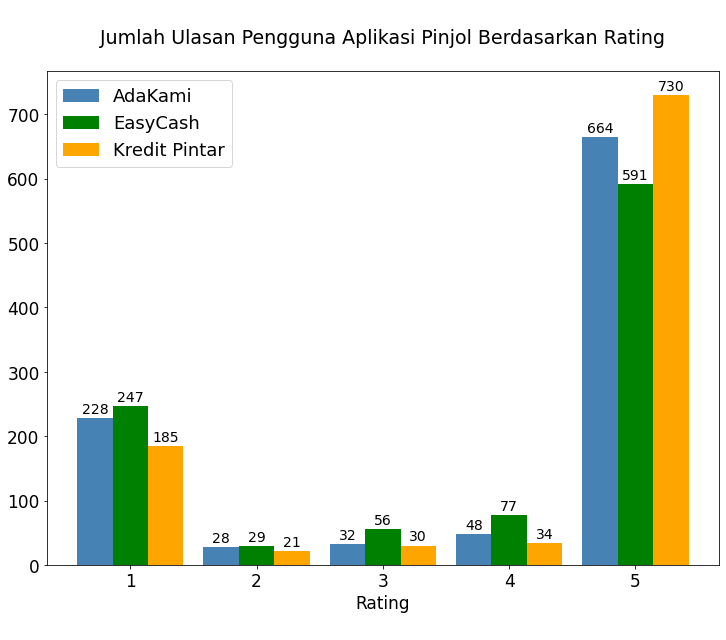

In [ ]:
#Rating Trend
ratingParams = [['1', '2', '3', '4', '5'],
                df_smps[0].groupby('score')['content'].count(),
                df_smps[1].groupby('score')['content'].count(),
                df_smps[2].groupby('score')['content'].count(),
                "Jumlah Ulasan Pengguna Aplikasi Pinjol Berdasarkan Rating"
                ]
visualizingData(*ratingParams)

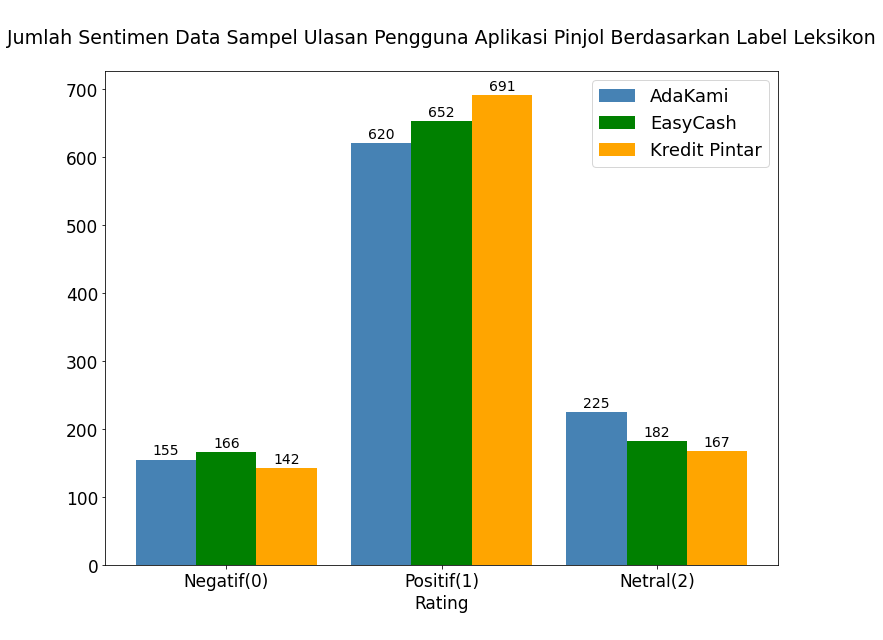

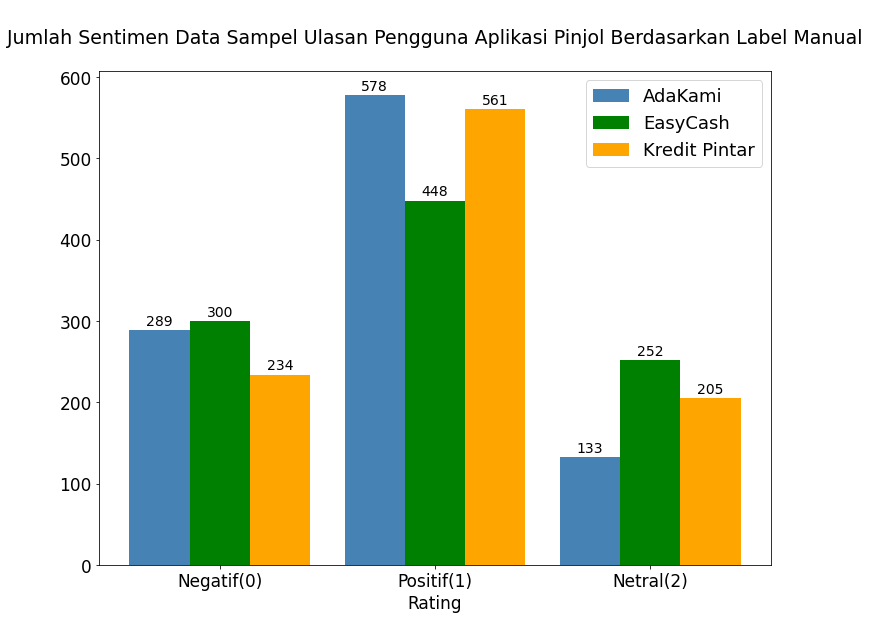

In [ ]:
# Label Trend
lab_methods = ['lex_label','mnl_label']
label_name = ['Label Leksikon', 'Label Manual']
for method, lbl in zip(lab_methods, label_name):
    labelParams = [['Negatif(0)', 'Positif(1)', 'Netral(2)'],
                   df_smps[0].groupby(method)['content'].count(),
                   df_smps[1].groupby(method)['content'].count(),
                   df_smps[2].groupby(method)['content'].count(),
                   'Jumlah Sentimen Data Sampel Ulasan Pengguna Aplikasi Pinjol Berdasarkan '+ lbl
                   ]
    visualizingData(*labelParams)
    print('=============================================================='+
           '=============================================================')

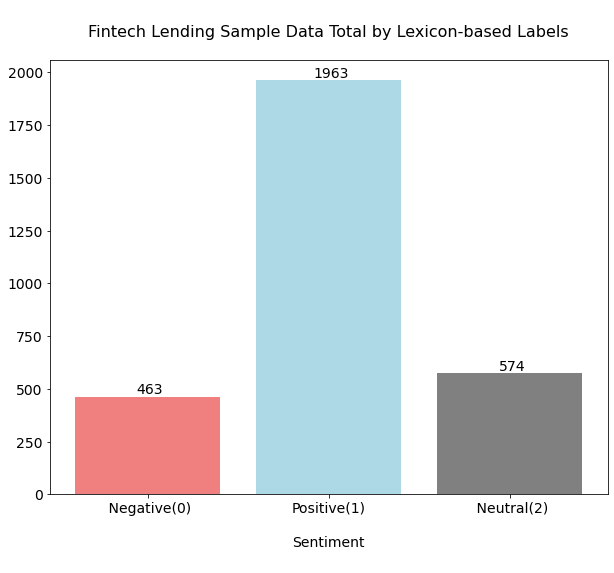

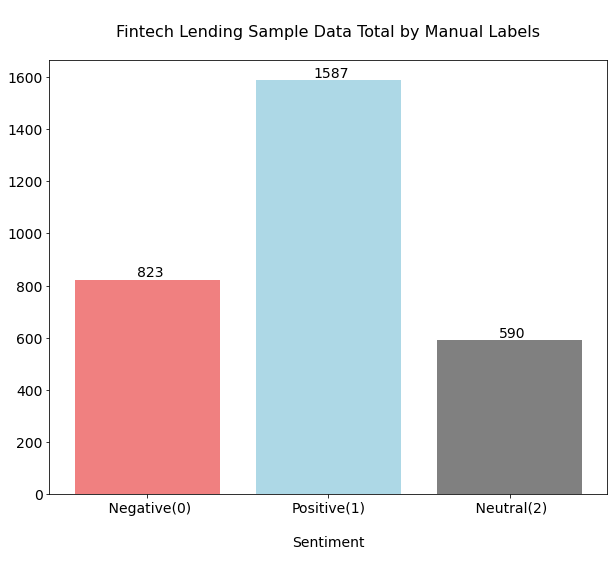

In [ ]:
# Additional
# create bar chart data sample by label
lab_methods = ['lex_label','mnl_label']
for method in lab_methods:
    y_counts = 0
    x = [' Negative(0)' ,'Positive(1)',' Neutral(2)']
    for df_smp in df_smps:
        y_counts += df_smp.groupby(method)['content'].count()
    y = y_counts
    fig, ax =  plt.subplots(figsize = (10, 8))
    ax.bar(x, y, color=('lightcoral','lightblue','grey'))
    for bar in ax.patches:
        ax.annotate(str(round(bar.get_height())), (bar.get_x(), bar.get_height())
                     ,ha='center',
                      va='center',
                      size=14,
                      xytext=(75, 7),
                      textcoords='offset points')
    if method == 'lex_label':
        m = 'Lexicon-based Labels\n'
    else:
        m = 'Manual Labels\n'
    plt.title('\nFintech Lending Sample Data Total by '+m, size=16)
    plt.ylim(bottom=0)
    plt.xlabel('\nSentiment\n', size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.show()
    print('=================================================================================')

#MODIFY

#####Data integration

In [ ]:
df_apps = pd.concat(df_smps, ignore_index=True)
df_apps

#####Atributes elimination

In [ ]:
df_apps = df_apps[['appName','content','lex_label','mnl_label']]
df_apps

,appName,content,lex_label,mnl_label
0,AdaKami,"Data saya mohon dihapus,,, karna pengajuan say...",1,2
1,AdaKami,"Nice, semoga limit semakin besar",1,1
2,AdaKami,Pinjaman dana yg sangat bermanfaat bagi yang s...,1,1
3,AdaKami,Good,1,1
4,AdaKami,Terima kasih ada kami setelah sekian lama akhi...,1,1
...,...,...,...,...
2995,Kredit Pintar,Sedikit agak lama yahh,2,0
2996,Kredit Pintar,"Akan bay ini aplikasi dari hp. Sekedar saran,k...",0,0
2997,Kredit Pintar,"terbantu sekali, terimakasih Kredit Pintar",1,1
2998,Kredit Pintar,👍,2,1


#####Text preprocessing

In [ ]:
# Case Folding
def caseFolding(content):
    return content.lower()

In [ ]:
# Cleaning
# compile regex pattern
clean_sym = re.compile('[^0-9A-Za-z]')
clean_num = re.compile('[0-9]+')
clean_dblspc = re.compile(' +')

In [ ]:
def cleaning(content):
    content = clean_sym.sub(' ', content)
    content = clean_num.sub(' ', content)
    content = clean_dblspc.sub(' ', content)
    return content

In [ ]:
# Tokenizing
def tokenize(content):
    return word_tokenize(content)

In [ ]:
# Normalize
norm_words = pd.read_excel('assets/norm.xlsx')

In [ ]:
#create dictionary
norm_word_dict = {}

for index, row in norm_words.iterrows():
    if row[0] not in norm_word_dict:
        norm_word_dict[row[0]] = row[1]

# nomalizing each word in content data
def normalize(content):
    return [
        norm_word_dict[word] if word in norm_word_dict else word for word in content
    ]

In [ ]:
nltk_stopwords = stopwords.words('indonesian')
txt_stopwords = open(
    'assets/stopwords.txt', 'r'
).read().split()

In [ ]:
all_stopword = nltk_stopwords + txt_stopwords
all_stopword = set(all_stopword)

def stopword_removal(content):
    return [word for word in content if word not in all_stopword]

In [ ]:
# Implementing
df_apps.insert(2, 'lowered', df_apps.iloc[:,1].apply(caseFolding))
df_apps.insert(3, 'cleaned', df_apps.iloc[:,2].apply(cleaning))
df_apps.insert(4, 'tokenized', df_apps.iloc[:,3].apply(tokenize))
df_apps.insert(5, 'normalized', df_apps.iloc[:,4].apply(normalize))
df_apps.insert(6, 'stopword_removed', df_apps.iloc[:,5].apply(stopword_removal))
df_apps

,appName,content,lowered,cleaned,tokenized,normalized,stopword_removed,lex_label,mnl_label
0,AdaKami,"Data saya mohon dihapus,,, karna pengajuan say...","data saya mohon dihapus,,, karna pengajuan say...",data saya mohon dihapus karna pengajuan saya d...,"[data, saya, mohon, dihapus, karna, pengajuan,...","[data, saya, mohon, dihapus, karena, pengajuan...","[data, mohon, dihapus, pengajuan, tolak, terim...",1,2
1,AdaKami,"Nice, semoga limit semakin besar","nice, semoga limit semakin besar",nice semoga limit semakin besar,"[nice, semoga, limit, semakin, besar]","[bagus, semoga, limit, semakin, besar]","[bagus, semoga, limit]",1,1
2,AdaKami,Pinjaman dana yg sangat bermanfaat bagi yang s...,pinjaman dana yg sangat bermanfaat bagi yang s...,pinjaman dana yg sangat bermanfaat bagi yang s...,"[pinjaman, dana, yg, sangat, bermanfaat, bagi,...","[pinjaman, dana, yang, sangat, bermanfaat, bag...","[pinjaman, dana, bermanfaat, membutuhkan]",1,1
3,AdaKami,Good,good,good,[good],[bagus],[bagus],1,1
4,AdaKami,Terima kasih ada kami setelah sekian lama akhi...,terima kasih ada kami setelah sekian lama akhi...,terima kasih ada kami setelah sekian lama akhi...,"[terima, kasih, ada, kami, setelah, sekian, la...","[terima, kasih, ada, kami, setelah, sekian, la...","[terima, kasih, sekian, acc]",1,1
...,...,...,...,...,...,...,...,...,...
2995,Kredit Pintar,Sedikit agak lama yahh,sedikit agak lama yahh,sedikit agak lama yahh,"[sedikit, agak, lama, yahh]","[sedikit, agak, lama, yahh]",[],2,0
2996,Kredit Pintar,"Akan bay ini aplikasi dari hp. Sekedar saran,k...","akan bay ini aplikasi dari hp. sekedar saran,k...",akan bay ini aplikasi dari hp sekedar saran kl...,"[akan, bay, ini, aplikasi, dari, hp, sekedar, ...","[akan, bayar, ini, aplikasi, dari, telepon gen...","[bayar, aplikasi, telepon genggam, saran, peng...",0,0
2997,Kredit Pintar,"terbantu sekali, terimakasih Kredit Pintar","terbantu sekali, terimakasih kredit pintar",terbantu sekali terimakasih kredit pintar,"[terbantu, sekali, terimakasih, kredit, pintar]","[terbantu, sekali, terima kasih, kredit, pintar]","[terbantu, terima kasih, kredit, pintar]",1,1
2998,Kredit Pintar,👍,👍,,[],[],[],2,1


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def stemming(word):
    return stemmer.stem(word)

word_dict = {}

for content in df_apps['stopword_removed']:
    for word in content:
        word_dict[word] = ' '

print(len(word_dict))
print('============================')
for word in word_dict:
    word_dict[word] = stemming(word)
    print(word,':' ,word_dict[word])

In [ ]:
def stemming_content(content):
    return [word_dict[word] for word in content]
df_apps.insert(
    7,
    'stemmed',
    df_apps.iloc[:,6].swifter.apply(stemming_content)
)

Pandas Apply:   0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
# implementing
df_apps.insert(7, 'stemmed', df_apps.iloc[:,6].swifter.apply(stemming_content))

Pandas Apply:   0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
# compare result
df_apps

,appName,content,lowered,cleaned,tokenized,normalized,stopword_removed,stemmed,lex_label,mnl_label
0,AdaKami,"Data saya mohon dihapus,,, karna pengajuan say...","data saya mohon dihapus,,, karna pengajuan say...",data saya mohon dihapus karna pengajuan saya d...,"[data, saya, mohon, dihapus, karna, pengajuan,...","[data, saya, mohon, dihapus, karena, pengajuan...","[data, mohon, dihapus, pengajuan, tolak, terim...","[data, mohon, hapus, aju, tolak, terima kasih]",1,2
1,AdaKami,"Nice, semoga limit semakin besar","nice, semoga limit semakin besar",nice semoga limit semakin besar,"[nice, semoga, limit, semakin, besar]","[bagus, semoga, limit, semakin, besar]","[bagus, semoga, limit]","[bagus, moga, limit]",1,1
2,AdaKami,Pinjaman dana yg sangat bermanfaat bagi yang s...,pinjaman dana yg sangat bermanfaat bagi yang s...,pinjaman dana yg sangat bermanfaat bagi yang s...,"[pinjaman, dana, yg, sangat, bermanfaat, bagi,...","[pinjaman, dana, yang, sangat, bermanfaat, bag...","[pinjaman, dana, bermanfaat, membutuhkan]","[pinjam, dana, manfaat, butuh]",1,1
3,AdaKami,Good,good,good,[good],[bagus],[bagus],[bagus],1,1
4,AdaKami,Terima kasih ada kami setelah sekian lama akhi...,terima kasih ada kami setelah sekian lama akhi...,terima kasih ada kami setelah sekian lama akhi...,"[terima, kasih, ada, kami, setelah, sekian, la...","[terima, kasih, ada, kami, setelah, sekian, la...","[terima, kasih, sekian, acc]","[terima, kasih, sekian, acc]",1,1
...,...,...,...,...,...,...,...,...,...,...
2995,Kredit Pintar,Sedikit agak lama yahh,sedikit agak lama yahh,sedikit agak lama yahh,"[sedikit, agak, lama, yahh]","[sedikit, agak, lama, yahh]",[],[],2,0
2996,Kredit Pintar,"Akan bay ini aplikasi dari hp. Sekedar saran,k...","akan bay ini aplikasi dari hp. sekedar saran,k...",akan bay ini aplikasi dari hp sekedar saran kl...,"[akan, bay, ini, aplikasi, dari, hp, sekedar, ...","[akan, bayar, ini, aplikasi, dari, telepon gen...","[bayar, aplikasi, telepon genggam, saran, peng...","[bayar, aplikasi, telepon genggam, saran, aju,...",0,0
2997,Kredit Pintar,"terbantu sekali, terimakasih Kredit Pintar","terbantu sekali, terimakasih kredit pintar",terbantu sekali terimakasih kredit pintar,"[terbantu, sekali, terimakasih, kredit, pintar]","[terbantu, sekali, terima kasih, kredit, pintar]","[terbantu, terima kasih, kredit, pintar]","[bantu, terima kasih, kredit, pintar]",1,1
2998,Kredit Pintar,👍,👍,,[],[],[],[],2,1


In [ ]:
# export comparation result
df_apps.to_excel('datasets/comparationPreprocessing.xlsx', index=False)

In [ ]:
# copy final result to content attribute and drop unnecessary attributes
df_apps.iloc[:,1] = df_apps.iloc[:,7]
df_apps = df_apps[['appName','content','lex_label','mnl_label']]
df_apps

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,appName,content,lex_label,mnl_label
0,AdaKami,"[data, mohon, hapus, aju, tolak, terima kasih]",1,2
1,AdaKami,"[bagus, moga, limit]",1,1
2,AdaKami,"[pinjam, dana, manfaat, butuh]",1,1
3,AdaKami,[bagus],1,1
4,AdaKami,"[terima, kasih, sekian, acc]",1,1
...,...,...,...,...
2995,Kredit Pintar,[],2,0
2996,Kredit Pintar,"[bayar, aplikasi, telepon genggam, saran, aju,...",0,0
2997,Kredit Pintar,"[bantu, terima kasih, kredit, pintar]",1,1
2998,Kredit Pintar,[],2,1


In [ ]:
# export cleaned
df_apps.to_excel('datasets/cleanedSampel.xlsx', index=False)

#####Term weighting

In [ ]:
df_fintechLend = pd.read_excel('datasets/cleanedSampel.xlsx')

In [ ]:
def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])

df_fintechLend.insert(2,'content_join', df_fintechLend['content'].apply(join_text_list))

In [ ]:
df_fintechLend = df_fintechLend[df_fintechLend['content_join'] != '' ].reset_index(drop=True)
display(df_fintechLend)

,appName,content,content_join,lex_label,mnl_label
0,AdaKami,"['data', 'mohon', 'hapus', 'aju', 'tolak', 'te...",data mohon hapus aju tolak terima kasih,1,2
1,AdaKami,"['bagus', 'moga', 'limit']",bagus moga limit,1,1
2,AdaKami,"['pinjam', 'dana', 'manfaat', 'butuh']",pinjam dana manfaat butuh,1,1
3,AdaKami,['bagus'],bagus,1,1
4,AdaKami,"['terima', 'kasih', 'sekian', 'acc']",terima kasih sekian acc,1,1
...,...,...,...,...,...
2875,Kredit Pintar,"['aplikasi', 'bagus', 'ribet', 'aju', 'pinjam'...",aplikasi bagus ribet aju pinjam moga kasih but...,1,1
2876,Kredit Pintar,"['terima kasih', 'bantu', 'modal', 'usaha']",terima kasih bantu modal usaha,1,1
2877,Kredit Pintar,"['bayar', 'aplikasi', 'telepon genggam', 'sara...",bayar aplikasi telepon genggam saran aju tolak...,0,0
2878,Kredit Pintar,"['bantu', 'terima kasih', 'kredit', 'pintar']",bantu terima kasih kredit pintar,1,1


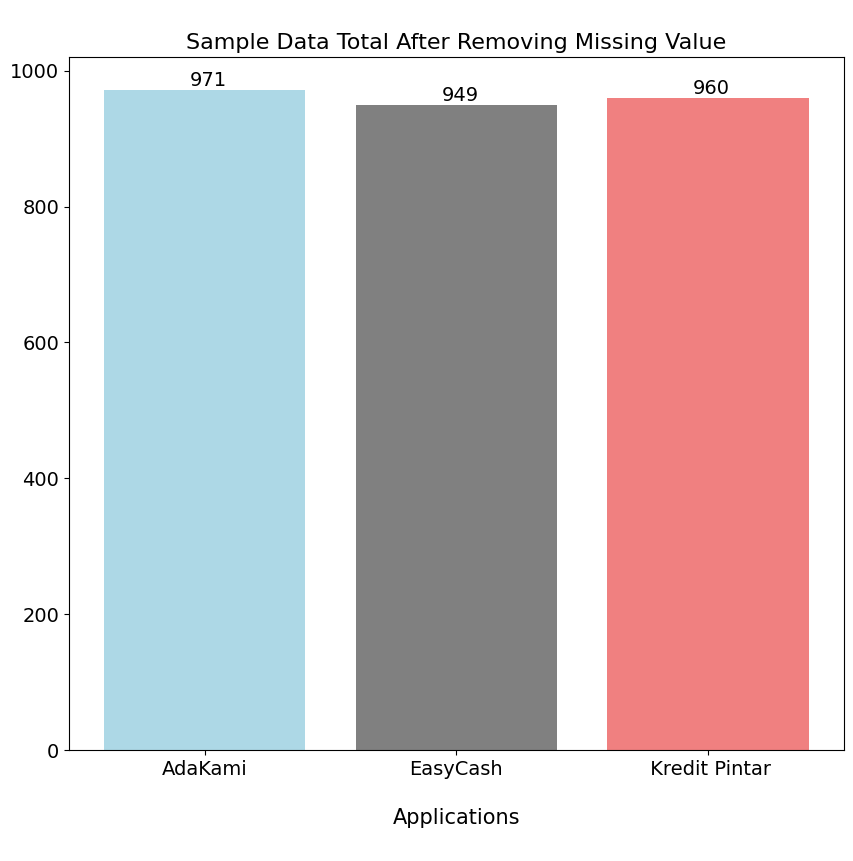

In [ ]:
# Sample Data Total After Removing Missing Value
x = ['AdaKami' ,'EasyCash',' Kredit Pintar']
y = df_fintechLend['appName'].value_counts().sort_index()
fig, ax =  plt.subplots(figsize = (10, 9))
ax.bar(x, y, color=('lightblue','grey','lightcoral'))
for bar in ax.patches:
    ax.annotate(str(round(bar.get_height())), (bar.get_x(), bar.get_height())
                 ,ha='center',
                  va='center',
                  size=14,
                  xytext=(75, 7),
                  textcoords='offset points')
plt.title('\nSample Data Total After Removing Missing Value', size=16)
plt.ylim(bottom=0)
plt.xlabel('\nApplications\n', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

In [ ]:
# Split data by appName
grouped = df_fintechLend.groupby(df_fintechLend.appName)

df_adakami = grouped.get_group("AdaKami")
df_easycash = grouped.get_group("EasyCash").reset_index(drop=True)
df_kreditpintar = grouped.get_group("Kredit Pintar").reset_index(drop=True)

dfs = [df_adakami, df_easycash, df_kreditpintar]
nm = ['AdaKami', 'EasyCash', 'Kredit Pintar']

In [ ]:
#TF - IDF process
vectorizer = TfidfVectorizer(use_idf = True)
tfidf_vectors = []
df_features_apps = []
dfs_tfidf = []
# counting TF
for df,n in zip(dfs,nm):
    tfidf_vector = vectorizer.fit_transform(df['content_join'])
    tfidf_vectors.append(tfidf_vector)
    print(n+'\n')
    display(tfidf_vector)
    print('\n')
    print(tfidf_vector)
    # create list feature names adakami, easycash, kredit pintar
    df_features = pd.DataFrame(
        vectorizer.get_feature_names_out(),
        columns=['Feature Names '+n]
    )
    df_features_apps.append(df_features)
    # create df tfidf
    df_tfidf = pd.DataFrame(tfidf_vector.todense().T,
                            index=vectorizer.get_feature_names_out(),
                            columns=[f'D{i+1}' for i in range (len(df))])
    dfs_tfidf.append(df_tfidf)
    print('==========================================')

AdaKami



<971x721 sparse matrix of type '<class 'numpy.float64'>'
	with 4745 stored elements in Compressed Sparse Row format>



  (0, 297)	0.31108569905867955
  (0, 664)	0.32406791468938567
  (0, 680)	0.3774489507561184
  (0, 12)	0.3697733629971226
  (0, 225)	0.42488525354155493
  (0, 423)	0.45016951229582064
  (0, 160)	0.3685451880342777
  (1, 366)	0.687664056545847
  (1, 422)	0.5986018463507548
  (1, 52)	0.41084543916219585
  (2, 123)	0.5184080460162944
  (2, 389)	0.6641502280047535
  (2, 153)	0.4633131652189789
  (2, 502)	0.27476987353342147
  (3, 52)	1.0
  (4, 3)	0.5059800051869677
  (4, 576)	0.7077717827571248
  (4, 297)	0.341403078017823
  (4, 664)	0.35565049726347
  (5, 658)	0.3438270333621102
  (5, 438)	0.5427121652300406
  (5, 79)	0.2917557839674267
  (5, 261)	0.41389715663605114
  (5, 427)	0.5751644835096094
  (6, 641)	0.9204736390925282
  :	:
  (969, 239)	0.23511868155464158
  (969, 266)	0.24553586768047786
  (969, 656)	0.24553586768047786
  (969, 237)	0.22043648233834165
  (969, 267)	0.2100192962125054
  (969, 395)	0.18975518391591126
  (969, 406)	0.23511868155464158
  (969, 647)	0.176839713564331

<949x717 sparse matrix of type '<class 'numpy.float64'>'
	with 4677 stored elements in Compressed Sparse Row format>



  (0, 111)	0.333196468047478
  (0, 365)	0.4700267941434035
  (0, 35)	0.22428062789492464
  (0, 397)	0.25245416666647985
  (0, 478)	0.549828490182161
  (0, 114)	0.31931412756391775
  (0, 92)	0.31317072315852984
  (0, 273)	0.22731308283997884
  (1, 84)	0.8553489702802963
  (1, 367)	0.5180522551253266
  (2, 145)	0.5077175571201494
  (2, 209)	0.5793767618566126
  (2, 64)	0.4605974298190761
  (2, 35)	0.44090300254880893
  (3, 494)	0.10279810639142711
  (3, 565)	0.2665407233797036
  (3, 363)	0.24074931870613112
  (3, 331)	0.162230117987913
  (3, 29)	0.22566231413116683
  (3, 650)	0.48012214223389726
  (3, 652)	0.17904809194760618
  (3, 250)	0.1847839048826301
  (3, 648)	0.17731712256287724
  (3, 60)	0.14676914914334935
  (3, 272)	0.2031085272364497
  :	:
  (945, 190)	0.14404065305981253
  (945, 8)	0.09152884907648756
  (945, 192)	0.08449765268131897
  (945, 496)	0.15538462891507138
  (945, 64)	0.24170440559990902
  (945, 35)	0.07712316747702748
  (945, 273)	0.07816593489206933
  (946, 213)

<960x677 sparse matrix of type '<class 'numpy.float64'>'
	with 4934 stored elements in Compressed Sparse Row format>



  (0, 421)	1.0
  (1, 38)	0.22804979413752616
  (1, 71)	0.5280845750181584
  (1, 449)	0.3787779143491193
  (1, 462)	0.4655943215405817
  (1, 304)	0.45920343106633543
  (1, 259)	0.2165961032578544
  (1, 626)	0.22602550591169474
  (2, 51)	1.0
  (3, 278)	0.4463937598110398
  (3, 23)	0.317017860078972
  (3, 634)	0.6806600672949488
  (3, 412)	0.30632591170560597
  (3, 112)	0.22430937081819222
  (3, 119)	0.18432926468626845
  (3, 477)	0.2425007722541195
  (4, 8)	0.47443259725880005
  (4, 23)	0.7610013468819267
  (4, 119)	0.44248238462357214
  (5, 526)	0.6638858460543138
  (5, 459)	0.2679503510747962
  (5, 182)	0.6419517169243607
  (5, 38)	0.27451081200110694
  (6, 318)	0.668919848856762
  (6, 248)	0.5291174703134822
  :	:
  (957, 614)	0.27521931138952616
  (957, 564)	0.246801433089949
  (957, 54)	0.23527389757355172
  (957, 109)	0.24431828640130893
  (957, 636)	0.23741446794352583
  (957, 69)	0.2037775178354505
  (957, 8)	0.19717444478573257
  (957, 38)	0.17373937706753956
  (958, 61)	0.426

In [ ]:
# feature names adakami, easycash, kredit pintar
for df_features in df_features_apps:
    display(df_features)

,Feature Names AdaKami
0,aangat
1,abal
2,acak
3,acc
4,acung
...,...
716,wajib
717,walaupun
718,waras
719,yang


,Feature Names EasyCash
0,abis
1,acara
2,acc
3,admin
4,administrasi
...,...
712,via
713,wajah
714,wajar
715,wajib


,Feature Names Kredit Pintar
0,abai
1,acc
2,ada
3,admin
4,adminnya
...,...
672,verifikasi
673,viral
674,wajib
675,whatsapp


In [ ]:
for df_tfidf,n in zip(dfs_tfidf,nm):
    print('\n'+n+'\n')
    display(df_tfidf)
    # eksport
    df_tfidf.to_excel('datasets/TFIDF_Result-{}.xlsx'.format(n))


AdaKami



,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D962,D963,D964,D965,D966,D967,D968,D969,D970,D971
aangat,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abal,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acak,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acc,0.0,0.0,0.0,0.0,0.50598,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acung,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wajib,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.367901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
walaupun,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
waras,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yang,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



EasyCash



,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D940,D941,D942,D943,D944,D945,D946,D947,D948,D949
abis,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acara,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acc,0.0,0.0,0.0,0.0,0.146207,0.066398,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
admin,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
administrasi,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
via,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wajah,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wajar,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wajib,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Kredit Pintar



,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D951,D952,D953,D954,D955,D956,D957,D958,D959,D960
abai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.29656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
admin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adminnya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verifikasi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
viral,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wajib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
whatsapp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#MODEL

#####Split data and implement default SVM (using default kernel and parameters, without Grid Search to find best kernels and parameters)

In [ ]:
# splitting data scenarios
prop_scenarios = [0.1, 0.2, 0.3, 0.4, 0.5]
# container to hold the scenario description
scenario_desc = []
# container x and y - test and train
# for lexicon label and manual label
xtr_lex, ytr_lex, xte_lex, yte_lex = [],[],[],[]
xtr_mnl, ytr_mnl, xte_mnl, yte_mnl = [],[],[],[]

In [ ]:
adaKami_lex, adaKami_man, adaKami_lex_gscv, adaKami_man_gscv = [], [], [], []
easyCash_lex, easyCash_man, easyCash_lex_gscv, easyCash_man_gscv = [], [], [], []
kreditPintar_lex, kreditPintar_man, kreditPintar_lex_gscv, kreditPintar_man_gscv = [], [], [], []

######Lexicon-based Label

In [ ]:
for tfidf_vector, df, n in zip(tfidf_vectors, dfs, nm):
    for proportion in prop_scenarios:
        # splitting data according to the scenario
        x_train, x_test, y_train, y_test = train_test_split(tfidf_vector, df['lex_label'],
                                                            test_size = proportion, random_state = 1)
        # accommodate data in a list container
        xtr_lex.append(x_train)
        xte_lex.append(x_test)
        ytr_lex.append(y_train)
        yte_lex.append(y_test)

        # fill scenario_desc list
        test = int(proportion*100)
        train = int(100 - test)
        scenario_desc.append('Train : Test\t = '+str(train)+' : '+str(test)+'\nApplication Name = '+n)

In [ ]:
no = 0
ak_bestAccLex, ec_bestAccLex, kp_bestAccLex = 0, 0, 0

print('\tLEXICON BASED LABEL')
print('=================================\n')

for description, x_train, x_test, y_train, y_test in zip (scenario_desc, xtr_lex, xte_lex, ytr_lex, yte_lex):
    no+=1
    # split description words
    w = description.split()
    # implementing svm algoritm
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    svm_model_score = svm_model.score(x_test, y_test)
    y_pred = svm_model.predict(x_test)
    svm_model_f1score = f1_score(y_test, y_pred, average='weighted')
    # get best model (each app) and it variabels
    if w[-1] == 'AdaKami':
        ak_accLex = svm_model_score
        adaKami_lex.append(round(ak_accLex, 2))
        if ak_accLex > ak_bestAccLex:
            ak_bestAccLex = ak_accLex
            akModel_lex = svm_model
            Xtest_ak_lex = x_test
            Ytest_ak_lex = y_test
            ypred_ak_lex = svm_model.predict(x_test)
    elif w[-1] == 'EasyCash':
        ec_accLex = svm_model_score
        easyCash_lex.append(round(ec_accLex, 2))
        if ec_accLex > ec_bestAccLex:
            ec_bestAccLex = ec_accLex
            ecModel_lex = svm_model
            Xtest_ec_lex = x_test
            Ytest_ec_lex = y_test
            ypred_ec_lex = svm_model.predict(x_test)
    elif w[-1] == 'Pintar':
        kp_accLex = svm_model_score
        kreditPintar_lex.append(round(kp_accLex, 2))
        if kp_accLex > kp_bestAccLex:
            kp_bestAccLex = kp_accLex
            kpModel_lex = svm_model
            Xtest_kp_lex = x_test
            Ytest_kp_lex = y_test
            ypred_kp_lex = svm_model.predict(x_test)
    print('Scenario ' + str(no))
    print(description)
    print('Train\t\t: ', (x_train.shape, y_train.shape),
          '\nTest\t\t: ', (x_test.shape, y_test.shape))
    print('Accuracy\t: ', svm_model_score)
    print('F1-Score\t: ', svm_model_f1score)
    print('===========================================\n')

	LEXICON BASED LABEL

Scenario 1
Train : Test	 = 90 : 10
Application Name = AdaKami
Train		:  ((873, 721), (873,)) 
Test		:  ((98, 721), (98,))
Accuracy	:  0.7959183673469388
F1-Score	:  0.7868866296518608

Scenario 2
Train : Test	 = 80 : 20
Application Name = AdaKami
Train		:  ((776, 721), (776,)) 
Test		:  ((195, 721), (195,))
Accuracy	:  0.7948717948717948
F1-Score	:  0.780721853929401

Scenario 3
Train : Test	 = 70 : 30
Application Name = AdaKami
Train		:  ((679, 721), (679,)) 
Test		:  ((292, 721), (292,))
Accuracy	:  0.7671232876712328
F1-Score	:  0.7473061944159192

Scenario 4
Train : Test	 = 60 : 40
Application Name = AdaKami
Train		:  ((582, 721), (582,)) 
Test		:  ((389, 721), (389,))
Accuracy	:  0.7532133676092545
F1-Score	:  0.7269768300143596

Scenario 5
Train : Test	 = 50 : 50
Application Name = AdaKami
Train		:  ((485, 721), (485,)) 
Test		:  ((486, 721), (486,))
Accuracy	:  0.7016460905349794
F1-Score	:  0.6520562335547644

Scenario 6
Train : Test	 = 90 : 10
Application

######Manual Label

In [ ]:
for tfidf_vector, df, n in zip(tfidf_vectors, dfs, nm):
    for proportion in prop_scenarios:
        # splitting data according to the scenario
        x_train, x_test, y_train, y_test = train_test_split(tfidf_vector, df['mnl_label'],
                                                            test_size = proportion, random_state = 1)
        # accommodate data in a list container
        xtr_mnl.append(x_train)
        xte_mnl.append(x_test)
        ytr_mnl.append(y_train)
        yte_mnl.append(y_test)

In [ ]:
no = 0
ak_bestAccMnl, ec_bestAccMnl, kp_bestAccMnl = 0, 0, 0

print('\tMANUAL LABEL')
print('=================================\n')

for description, x_train, x_test, y_train, y_test in zip (scenario_desc, xtr_mnl, xte_mnl, ytr_mnl, yte_mnl):
    no+=1
    # split description words
    w = description.split()
    # implementing svm algoritm
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    svm_model_score = svm_model.score(x_test, y_test)
    y_pred = svm_model.predict(x_test)
    svm_model_f1score = f1_score(y_test, y_pred, average='weighted')
    # get best model (each app) and it variabels
    if w[-1] == 'AdaKami':
        ak_accMnl = svm_model_score
        adaKami_man.append(round(ak_accMnl, 2))
        if ak_accMnl > ak_bestAccMnl:
            ak_bestAccMnl = ak_accMnl
            akModel_mnl = svm_model
            Xtest_ak_mnl = x_test
            Ytest_ak_mnl = y_test
            ypred_ak_mnl = svm_model.predict(x_test)
    elif w[-1] == 'EasyCash':
        ec_accMnl = svm_model_score
        easyCash_man.append(round(ec_accMnl, 2))
        if ec_accMnl > ec_bestAccMnl:
            ec_bestAccMnl = ec_accMnl
            ecModel_mnl = svm_model
            Xtest_ec_mnl = x_test
            Ytest_ec_mnl = y_test
            ypred_ec_mnl = svm_model.predict(x_test)
    elif w[-1] == 'Pintar':
        kp_accMnl = svm_model_score
        kreditPintar_man.append(round(kp_accMnl, 2))
        if kp_accMnl > kp_bestAccMnl:
            kp_bestAccMnl = kp_accMnl
            kpModel_mnl = svm_model
            Xtest_kp_mnl = x_test
            Ytest_kp_mnl = y_test
            ypred_kp_mnl = svm_model.predict(x_test)
    print('Scenario ' + str(no))
    print(description)
    print('Train\t\t: ', (x_train.shape, y_train.shape),
          '\nTest\t\t: ', (x_test.shape, y_test.shape))
    print('Accuracy\t: ', svm_model_score)
    print('F1-Score\t: ', svm_model_f1score)
    print('===========================================\n')

	MANUAL LABEL

Scenario 1
Train : Test	 = 90 : 10
Application Name = AdaKami
Train		:  ((873, 721), (873,)) 
Test		:  ((98, 721), (98,))
Accuracy	:  0.9285714285714286
F1-Score	:  0.9219560705638187

Scenario 2
Train : Test	 = 80 : 20
Application Name = AdaKami
Train		:  ((776, 721), (776,)) 
Test		:  ((195, 721), (195,))
Accuracy	:  0.9076923076923077
F1-Score	:  0.8990658544234793

Scenario 3
Train : Test	 = 70 : 30
Application Name = AdaKami
Train		:  ((679, 721), (679,)) 
Test		:  ((292, 721), (292,))
Accuracy	:  0.9006849315068494
F1-Score	:  0.8884569094593954

Scenario 4
Train : Test	 = 60 : 40
Application Name = AdaKami
Train		:  ((582, 721), (582,)) 
Test		:  ((389, 721), (389,))
Accuracy	:  0.8868894601542416
F1-Score	:  0.8731388577965626

Scenario 5
Train : Test	 = 50 : 50
Application Name = AdaKami
Train		:  ((485, 721), (485,)) 
Test		:  ((486, 721), (486,))
Accuracy	:  0.8641975308641975
F1-Score	:  0.8388134157980743

Scenario 6
Train : Test	 = 90 : 10
Application Name 

#####Implementing Grid Search to find best kernel and parameters and refitting SVM Models

In [ ]:
param_scenarios = {
    'C':[0.10, 0.25, 0.5, 0.75, 1, 1.010, 1.025, 1.050, 1.075],
    'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel' : ['linear', 'rbf', 'poly']
}

In [ ]:
grid = GridSearchCV(
    SVC(),
    param_grid = param_scenarios,
    refit=(True),
    verbose=3,
    n_jobs=-1
)

######Lexicon-based Label

In [ ]:
no = 0
ak_bestAccLex, ec_bestAccLex, kp_bestAccLex = 0, 0, 0

print('\t\tLEXICON BASED LABEL (Refit)')
print('===============================================================\n')

for description, x_train, x_test, y_train, y_test in zip (scenario_desc, xtr_lex, xte_lex, ytr_lex, yte_lex):
    no+=1
    # split description words
    w = description.split()
    # implementing grid search
    grid.fit(x_train,y_train)
    # implementing svm algoritm with best kernel & params
    # (grid search cv result)
    svm_refitModel = svm.SVC(**grid.best_params_)
    svm_refitModel.fit(x_train, y_train)
    svm_refitModel_score = svm_refitModel.score(x_test, y_test)
    # get best model (each app) and it variabels
    if w[-1] == 'AdaKami':
        ak_accLex = svm_refitModel_score
        adaKami_lex_gscv.append(round(ak_accLex, 2))
        if ak_accLex > ak_bestAccLex:
            ak_bestAccLex = ak_accLex
            akRefitModel_lex = svm_refitModel
            XTest_ak_lex = x_test
            YTest_ak_lex = y_test
            yPred_ak_lex = svm_refitModel.predict(x_test)
    elif w[-1] == 'EasyCash':
        ec_accLex = svm_refitModel_score
        easyCash_lex_gscv.append(round(ec_accLex, 2))
        if ec_accLex > ec_bestAccLex:
            ec_bestAccLex = ec_accLex
            ecRefitModel_lex = svm_refitModel
            XTest_ec_lex = x_test
            YTest_ec_lex = y_test
            yPred_ec_lex = svm_refitModel.predict(x_test)
    elif w[-1] == 'Pintar':
        kp_accLex = svm_refitModel_score
        kreditPintar_lex_gscv.append(round(kp_accLex, 2))
        if kp_accLex > kp_bestAccLex:
            kp_bestAccLex = kp_accLex
            kpRefitModel_lex = svm_refitModel
            XTest_kp_lex = x_test
            YTest_kp_lex = y_test
            yPred_kp_lex = svm_refitModel.predict(x_test)
    print('Scenario ' + str(no))
    print(description)
    print('Train\t\t: ', (x_train.shape, y_train.shape),
          '\nTest\t\t: ', (x_test.shape, y_test.shape))
    print('Best Kernel and Parameters :')
    print(grid.best_params_)
    print('Accuracy\t: ', svm_refitModel_score)
    print('===============================================================\n')

		LEXICON BASED LABEL (Refit)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Scenario 1
Train : Test	 = 90 : 10
Application Name = AdaKami
Train		:  ((873, 721), (873,)) 
Test		:  ((98, 721), (98,))
Best Kernel and Parameters :
{'C': 1.01, 'gamma': 1, 'kernel': 'linear'}
Accuracy	:  0.7959183673469388

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Scenario 2
Train : Test	 = 80 : 20
Application Name = AdaKami
Train		:  ((776, 721), (776,)) 
Test		:  ((195, 721), (195,))
Best Kernel and Parameters :
{'C': 1.05, 'gamma': 1, 'kernel': 'linear'}
Accuracy	:  0.7948717948717948

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Scenario 3
Train : Test	 = 70 : 30
Application Name = AdaKami
Train		:  ((679, 721), (679,)) 
Test		:  ((292, 721), (292,))
Best Kernel and Parameters :
{'C': 1.05, 'gamma': 1, 'kernel': 'linear'}
Accuracy	:  0.7773972602739726

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Scenario 4
Train : Test	 = 60 : 

######Manual Label

In [ ]:
no = 0
ak_bestAccMnl, ec_bestAccMnl, kp_bestAccMnl = 0, 0, 0

print('\t\tMANUAL LABEL (Refit)')
print('===============================================================\n')

for description, x_train, x_test, y_train, y_test in zip (scenario_desc, xtr_mnl, xte_mnl, ytr_mnl, yte_mnl):
    no+=1
    # split description words
    w = description.split()
    # implementing grid search
    grid.fit(x_train,y_train)
    # implementing svm algoritm with best kernel & params
    # (grid search cv result)
    svm_refitModel = svm.SVC(**grid.best_params_)
    svm_refitModel.fit(x_train, y_train)
    svm_refitModel_score = svm_refitModel.score(x_test, y_test)
    # get best model (each app) and it variabels
    if w[-1] == 'AdaKami':
        ak_accMnl = svm_refitModel_score
        adaKami_man_gscv.append(round(ak_accMnl, 2))
        if ak_accMnl > ak_bestAccMnl:
            ak_bestAccMnl = ak_accMnl
            akRefitModel_mnl = svm_refitModel
            XTest_ak_mnl = x_test
            YTest_ak_mnl = y_test
            yPred_ak_mnl = svm_refitModel.predict(x_test)
    elif w[-1] == 'EasyCash':
        ec_accMnl = svm_refitModel_score
        easyCash_man_gscv.append(round(ec_accMnl, 2))
        if ec_accMnl > ec_bestAccMnl:
            ec_bestAccMnl = ec_accMnl
            ecRefitModel_mnl = svm_refitModel
            XTest_ec_mnl = x_test
            YTest_ec_mnl = y_test
            yPred_ec_mnl = svm_refitModel.predict(x_test)
    elif w[-1] == 'Pintar':
        kp_accMnl = svm_refitModel_score
        kreditPintar_man_gscv.append(round(kp_accMnl, 2))
        if kp_accMnl > kp_bestAccMnl:
            kp_bestAccMnl = kp_accMnl
            kpRefitModel_mnl = svm_refitModel
            XTest_kp_mnl = x_test
            YTest_kp_mnl = y_test
            yPred_kp_mnl = svm_refitModel.predict(x_test)
    print('Scenario ' + str(no))
    print(description)
    print('Train\t\t: ', (x_train.shape, y_train.shape),
          '\nTest\t\t: ', (x_test.shape, y_test.shape))
    print('Best Kernel and Parameters :')
    print(grid.best_params_)
    print('Accuracy\t: ', svm_refitModel_score)
    print('===============================================================\n')

		MANUAL LABEL (Refit)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Scenario 1
Train : Test	 = 90 : 10
Application Name = AdaKami
Train		:  ((873, 721), (873,)) 
Test		:  ((98, 721), (98,))
Best Kernel and Parameters :
{'C': 1.025, 'gamma': 1, 'kernel': 'rbf'}
Accuracy	:  0.9387755102040817

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Scenario 2
Train : Test	 = 80 : 20
Application Name = AdaKami
Train		:  ((776, 721), (776,)) 
Test		:  ((195, 721), (195,))
Best Kernel and Parameters :
{'C': 1.025, 'gamma': 1, 'kernel': 'rbf'}
Accuracy	:  0.9076923076923077

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Scenario 3
Train : Test	 = 70 : 30
Application Name = AdaKami
Train		:  ((679, 721), (679,)) 
Test		:  ((292, 721), (292,))
Best Kernel and Parameters :
{'C': 1.075, 'gamma': 1, 'kernel': 'linear'}
Accuracy	:  0.8835616438356164

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Scenario 4
Train : Test	 = 60 : 40
Applica

In [ ]:
def visualisasiAkurasi (Y1,Y2,Y3,Y4,i):
    labels = ['90:10', '80:20', '70:30', '60:40', '50:50']
    x = np.arange(len(labels))
    y1 = Y1
    y2 = Y2
    y3 = Y3
    y4 = Y4

    width = 0.20
    fig, ax = plt.subplots(figsize = (18, 12))
    plt.title('\nAkurasi Model Klasifikasi Sentimen Pengguna Aplikasi '+i +'\n', size=19)
    # plot data in grouped manner of bar type
    app1 = ax.bar(x-0.30, y1, width, color='lightskyblue')
    app2 = ax.bar(x-0.10, y2, width, color='dodgerblue')
    app3 = ax.bar(x+0.10, y3, width, color='greenyellow')
    app4 = ax.bar(x+0.30, y4, width, color='limegreen')
    ax.set_xticks(x, labels, size=16)
    ax.set_xlabel('\nSkenario Pembagian Data (Data Latih : Data Uji)\n', size=18)
    ax.legend(
        [
            'Lexicon',
            'Lexicon + Grid Search CV',
            'Manual',
            'Manual + Grid Search CV'
        ],
        prop={'size': 18},
        loc='upper center',
        bbox_to_anchor=(0.5, -0.13),
        fancybox=True,
        shadow=True,
        ncol=5
    )
    ax.bar_label(app1, padding=2, size=15)
    ax.bar_label(app2, padding=2, size=15)
    ax.bar_label(app3, padding=2, size=15)
    ax.bar_label(app4, padding=2, size=15)

    fig.tight_layout()
    plt.yticks(size=16)
    plt.show()

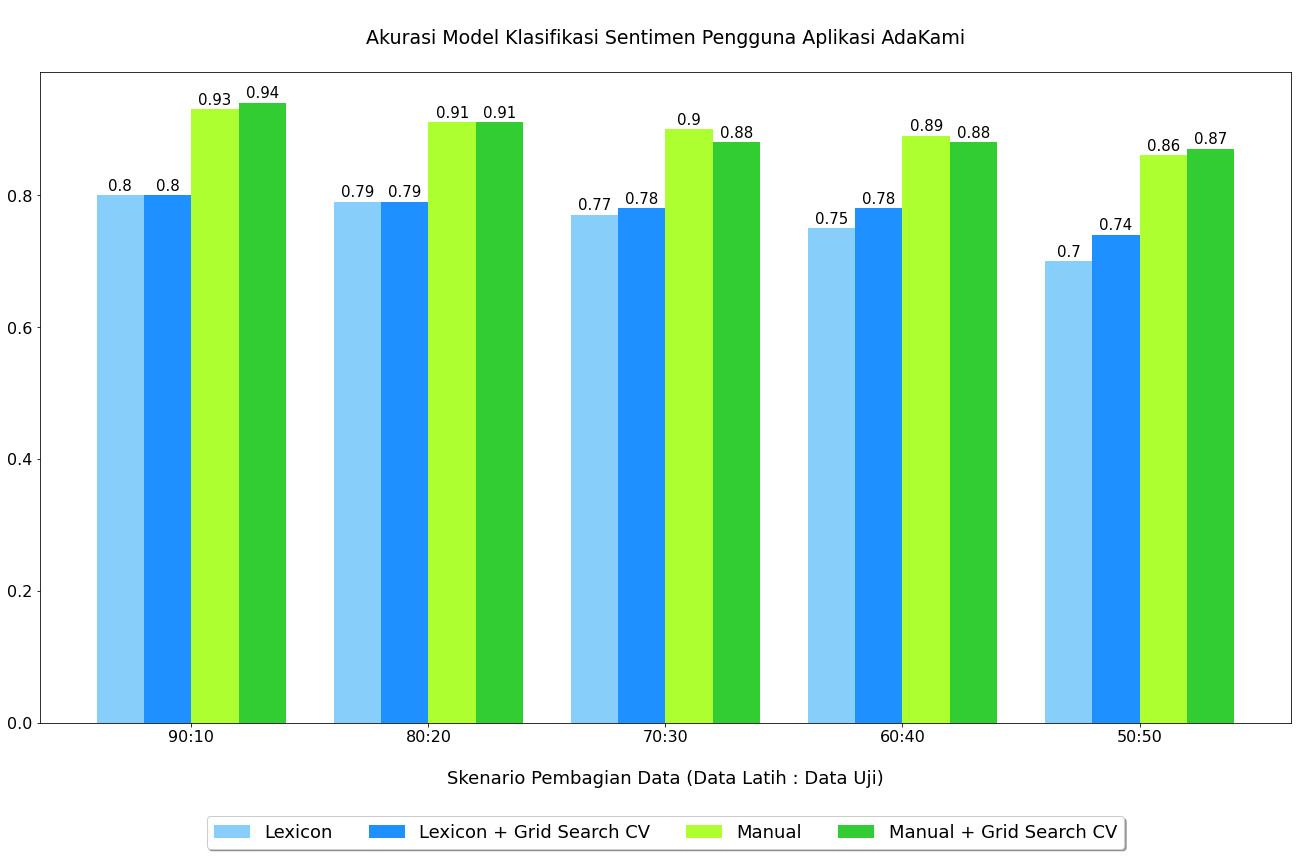

In [ ]:
#Akurasi model klasifikasi ulasan pengguna aplikasi AdaKami
visualisasiAkurasi(adaKami_lex, adaKami_lex_gscv, adaKami_man, adaKami_man_gscv, 'AdaKami')

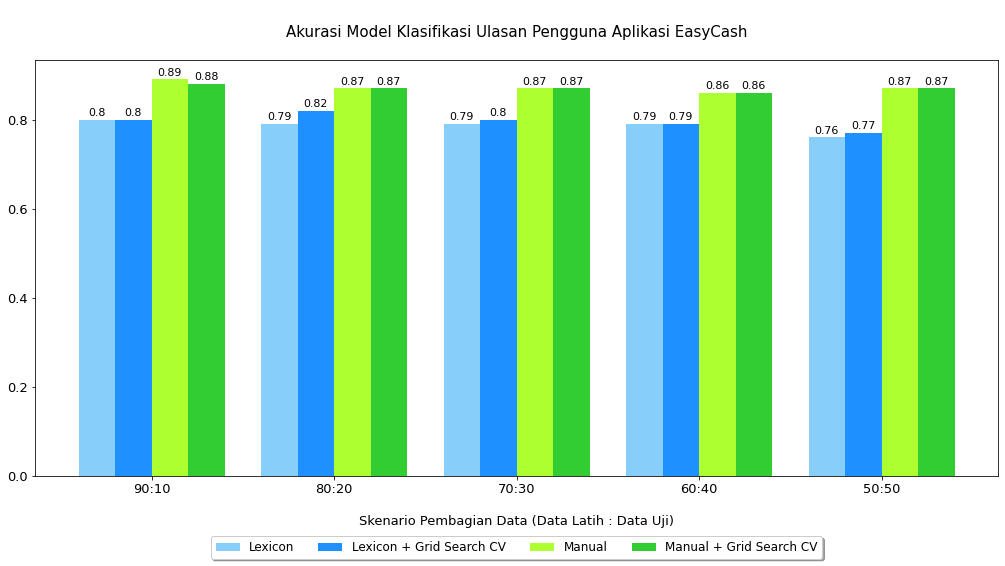

In [ ]:
#Akurasi model klasifikasi ulasan pengguna aplikasi EasyCash
visualisasiAkurasi(easyCash_lex, easyCash_lex_gscv, easyCash_man, easyCash_man_gscv, 'EasyCash')

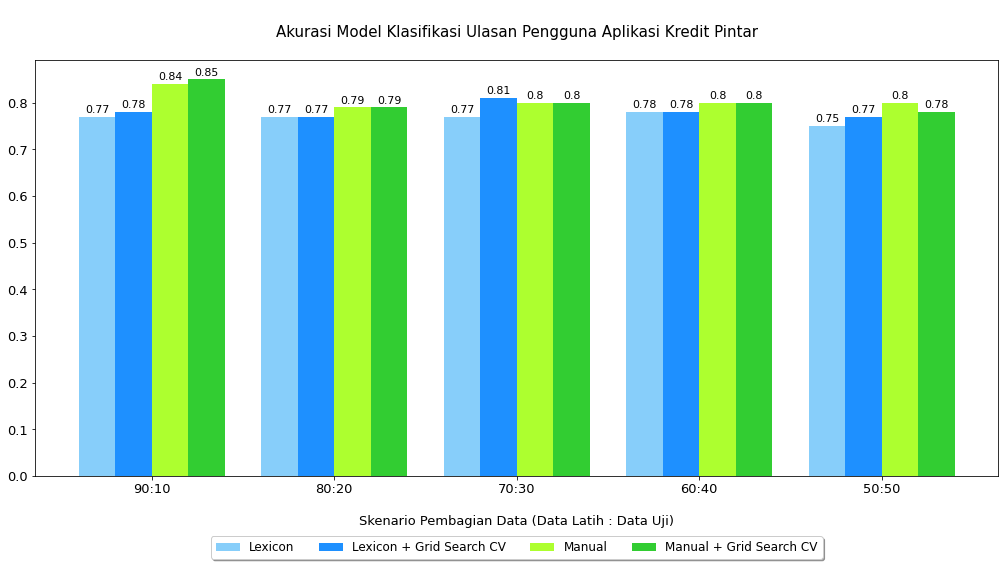

In [ ]:
#Akurasi model klasifikasi ulasan pengguna aplikasi Kredit Pintar
visualisasiAkurasi(kreditPintar_lex, kreditPintar_lex_gscv, kreditPintar_man, kreditPintar_man_gscv, 'Kredit Pintar')

#ASESS

#####Evaluate best models (one from each app and labeling method) with Confusion Matrix

In [ ]:
def eval (y_test, y_pred, methodLbl, appnm):
    f, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    #sns.set(font_scale=1.0)
    ax.tick_params(axis='both', which='major', labelsize=12)
    print('SVM Model Performance : '+appnm+'\n('+methodLbl+')\n')
    plt.show()
    print('__________________________________________________________\n')
    print(classification_report(y_test, y_pred, zero_division = 0, digits = 2))
    print('__________________________________________________________')
    print('\nAccuracy\t: ', accuracy_score(y_test, y_pred))
    print('Precision\t: ', precision_score(y_test, y_pred, average='macro'))
    print('Recall\t\t: ', recall_score(y_test, y_pred, average='macro'))
    print('F1-Score\t: ', f1_score(y_test, y_pred, average='macro'))
    print('\n=========================================================\n')

SVM Model Performance : AdaKami App
(Manual Label)



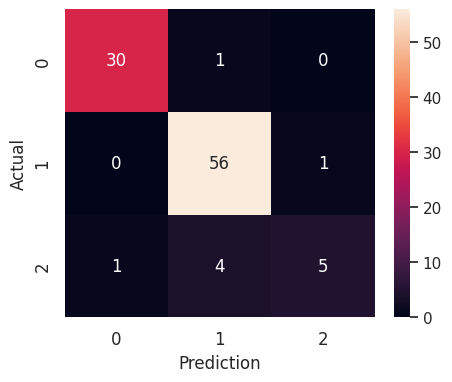

__________________________________________________________

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.92      0.98      0.95        57
           2       0.83      0.50      0.62        10

    accuracy                           0.93        98
   macro avg       0.91      0.82      0.85        98
weighted avg       0.93      0.93      0.92        98

__________________________________________________________

Accuracy	:  0.9285714285714286
Precision	:  0.9063693519008168
Recall		:  0.816732691944916
F1-Score	:  0.8472981592855842




In [ ]:
# Best SVM model Adakami app
eval(Ytest_ak_mnl, ypred_ak_mnl, 'Manual Label', 'AdaKami App')

SVM Model Performance : EasyCash App
(Manual Label)



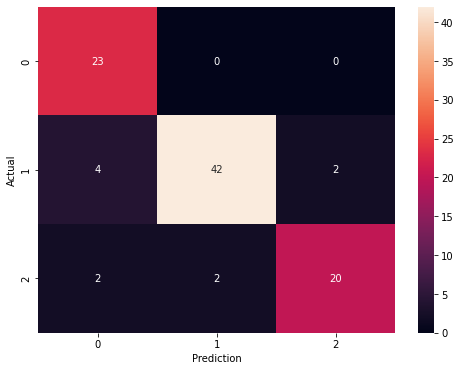

_______________________________________________________

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        23
           1       0.95      0.88      0.91        48
           2       0.91      0.83      0.87        24

    accuracy                           0.89        95
   macro avg       0.89      0.90      0.89        95
weighted avg       0.90      0.89      0.90        95

_______________________________________________________

Accuracy	:  0.8947368421052632
Precision	:  0.8855799373040752
Recall		:  0.9027777777777778
F1-Score	:  0.8890746934225194




In [ ]:
# Best SVM model Easycash app
eval(Ytest_ec_mnl, ypred_ec_mnl, 'Manual Label', 'EasyCash App')

SVM Model Performance : Kredit Pintar App
(Manual Label)



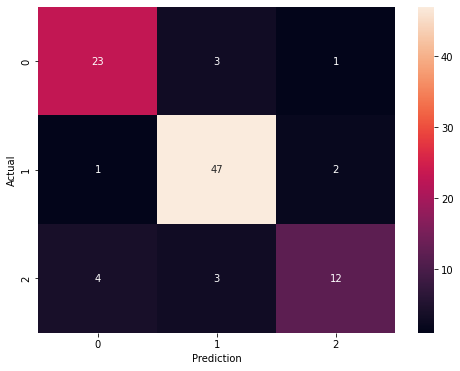

_______________________________________________________

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        27
           1       0.89      0.94      0.91        50
           2       0.80      0.63      0.71        19

    accuracy                           0.85        96
   macro avg       0.84      0.81      0.82        96
weighted avg       0.85      0.85      0.85        96

_______________________________________________________

Accuracy	:  0.8541666666666666
Precision	:  0.83607367475292
Recall		:  0.8078102664067576
F1-Score	:  0.8182891161760381




In [ ]:
# Best SVM model Kredit Pintar app
eval(YTest_kp_mnl, yPred_kp_mnl, 'Manual Label', 'Kredit Pintar App')

#####Export models to .pkl

In [ ]:
import joblib

In [ ]:
# Saving best model
def savingModel (filenm, model):
    filename = 'models/{}.pkl'.format(filenm)
    joblib.dump(model, open(filename, 'wb'))

In [ ]:
savingModel('AdaKami_Model', akRefitModel_mnl)
savingModel('EasyCash_Model', ecModel_mnl)
savingModel('KreditPintar_Model', kpRefitModel_mnl)

In [ ]:
# Try to load saved model and test it (again)
def load(filenm, x_test, y_test):
    loaded_model = joblib.load(open(filenm, 'rb'))
    result = loaded_model.score(x_test, y_test)
    print(result)

In [ ]:
load('models/AdaKami_Model.pkl', XTest_ak_mnl, YTest_ak_mnl)

0.9387755102040817


In [ ]:
load('models/EasyCash_Model.pkl', Xtest_ec_mnl, Ytest_ec_mnl)

0.8947368421052632


In [ ]:
load('models/KreditPintar_Model.pkl', XTest_kp_mnl, YTest_kp_mnl)

0.8541666666666666


# WORDCLOUD

In [ ]:
def blue_color(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return 'hsl(230, 100%%, %d%%)' % np.random.randint(49, 51)
def red_color(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return 'hsl(360, 100%%, %d%%)' % np.random.randint(49, 51)
def grey_color(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return 'hsl(230, 12%%, %d%%)' % np.random.randint(49, 51)
custom_colors = [blue_color,grey_color,red_color]

In [ ]:
mask = np.array(Image.open('assets/cloud.jpg'))

In [ ]:
pos1,neg1,neu1 = [],[],[]
pos2,neg2,neu2 = [],[],[]
pos3,neg3,neu3 = [],[],[]
for i, j, k, l in zip (df_fintechLend['lex_label'],df_fintechLend['mnl_label'],
                       df_fintechLend['content_join'], df_fintechLend['appName']):
    if l=='AdaKami':
        if i==1 and j==1:
            posWords = ''.join([contents for contents in k])
            pos1.append(posWords)
        elif i==2 and i==2:
            neuWords = ''.join([contents for contents in k])
            neu1.append(neuWords)
        elif i==0 and i==0:
            negWords = ''.join([contents for contents in k])
            neg1.append(negWords)
    elif l=='EasyCash':
        if i==1 and j==1:
            posWords = ''.join([contents for contents in k])
            pos2.append(posWords)
        elif i==2 and i==2:
            neuWords = ''.join([contents for contents in k])
            neu2.append(neuWords)
        elif i==0 and i==0:
            negWords = ''.join([contents for contents in k])
            neg2.append(negWords)
    else:
        if i==1 and j==1:
            posWords = ''.join([contents for contents in k])
            pos3.append(posWords)
        elif i==2 and i==2:
            neuWords = ''.join([contents for contents in k])
            neu3.append(neuWords)
        elif i==0 and i==0:
            negWords = ''.join([contents for contents in k])
            neg3.append(negWords)
adakami = [pos1, neu1, neg1]
easycash = [pos2, neu2, neg2]
kreditpintar = [pos3, neu3, neg3]

In [ ]:
# obj1 = AdaKami, obj2 = EasyCash,  obj3 = Kredit Pintar
obj1, obj2, obj3 = [], [], []
for i,j,k in zip(adakami,easycash,kreditpintar):
    i = ' '.join(i)
    j = ' '.join(j)
    k = ' '.join(k)
    obj1.append(i)
    obj2.append(j)
    obj3.append(k)
sentm = ['Positive', 'Neutral', 'Negative']
objects = ['AdaKami', 'EasyCash', 'Kredit Pintar']
apps = [obj1,obj2,obj3]


AdaKami



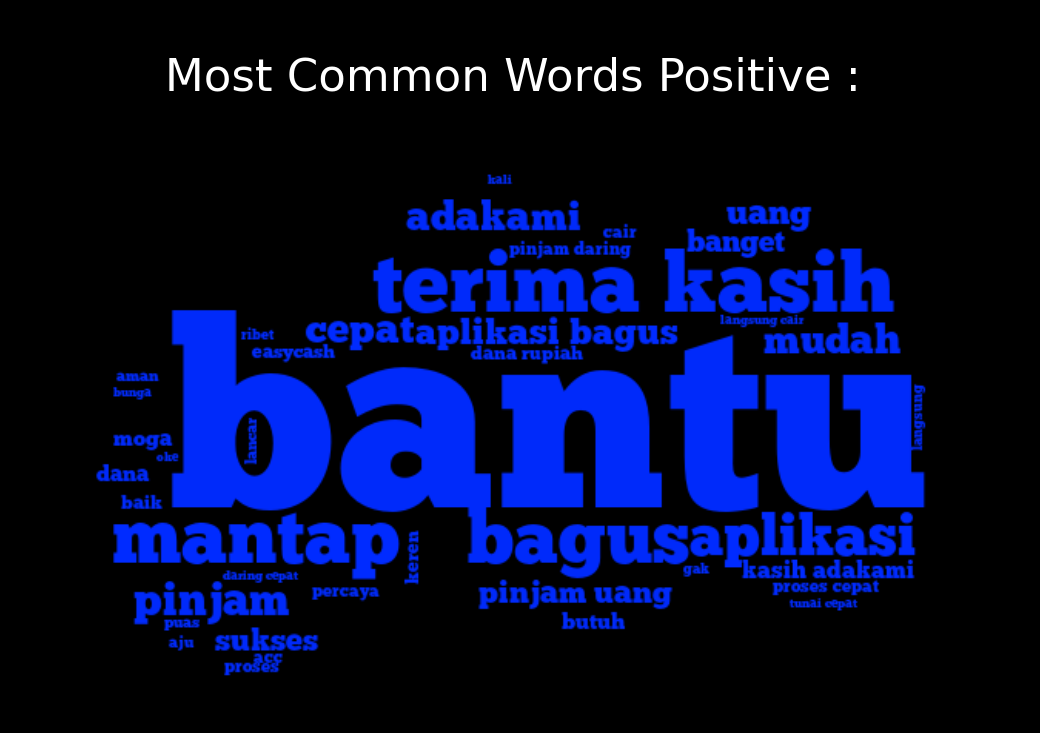

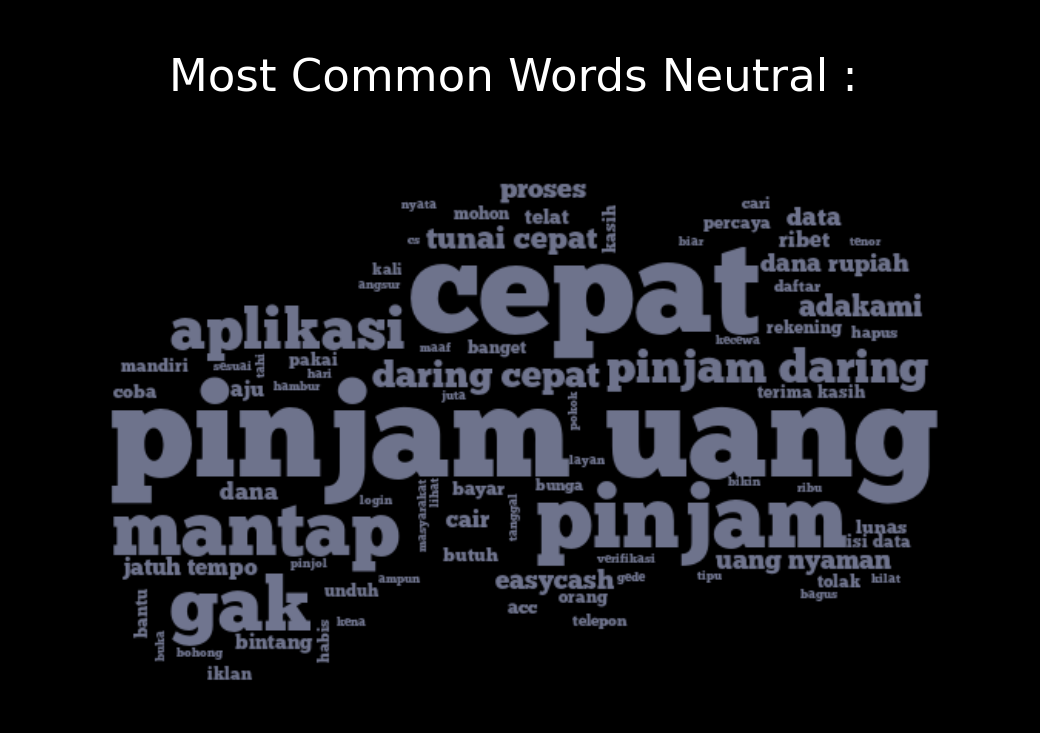

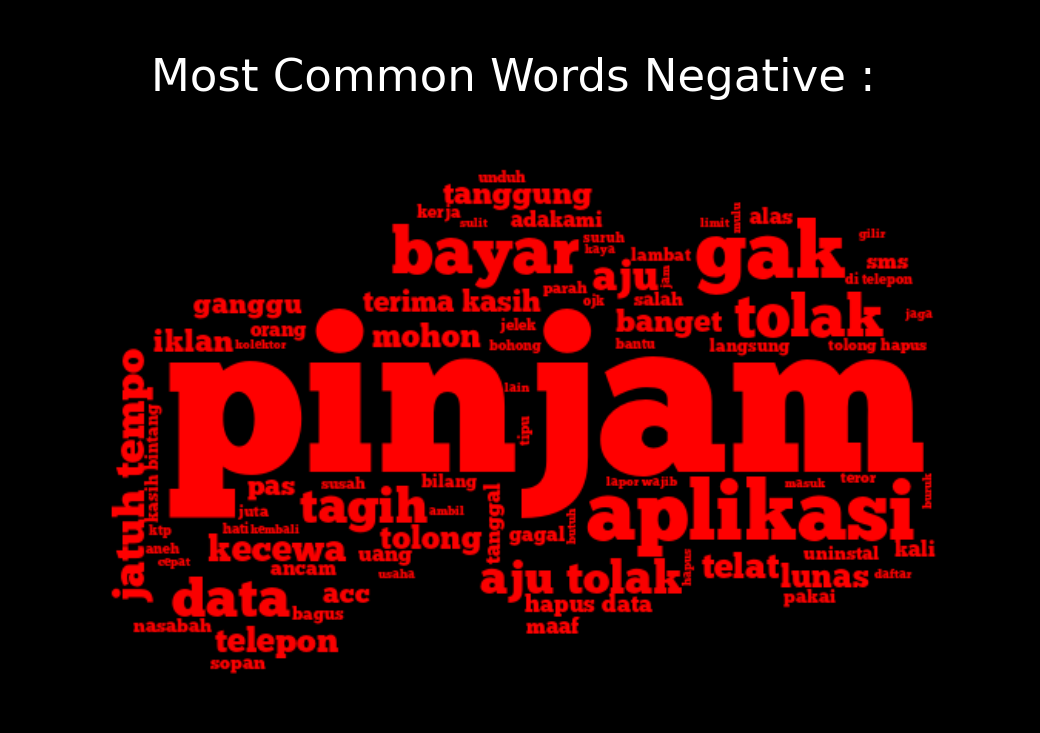


EasyCash



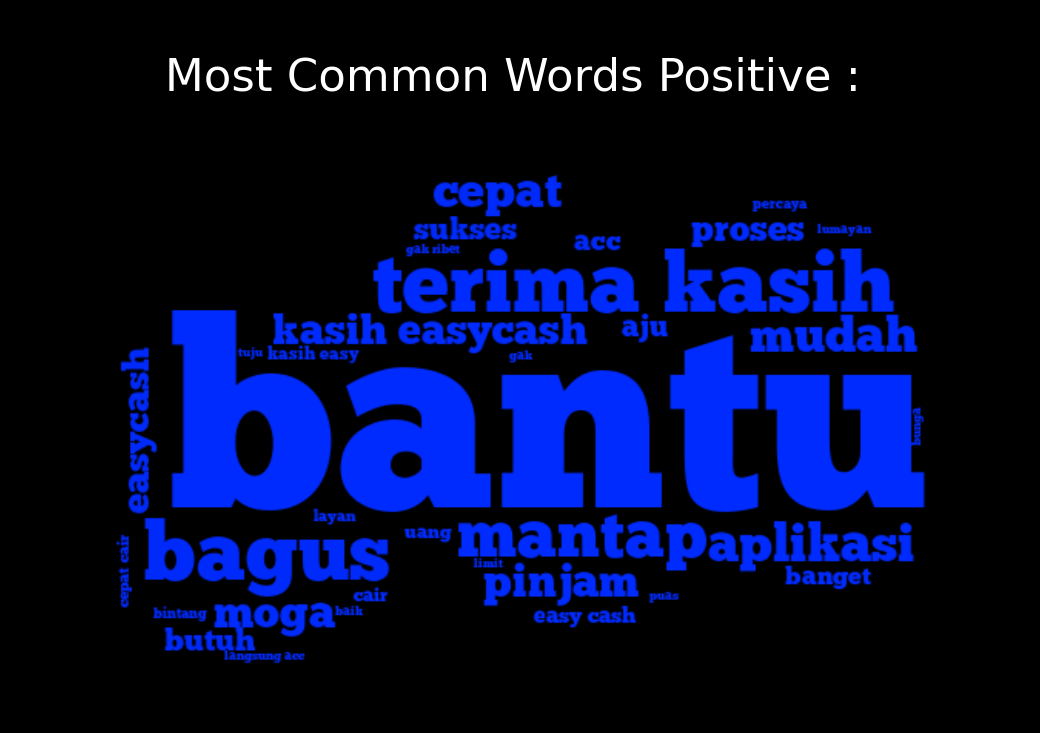

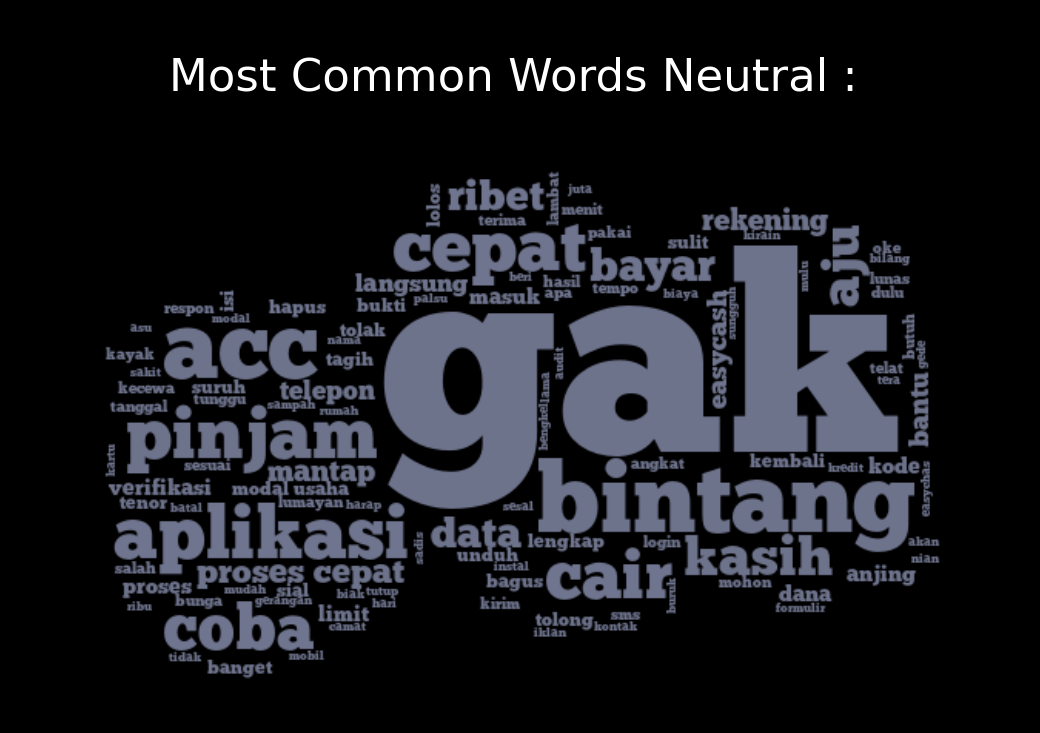

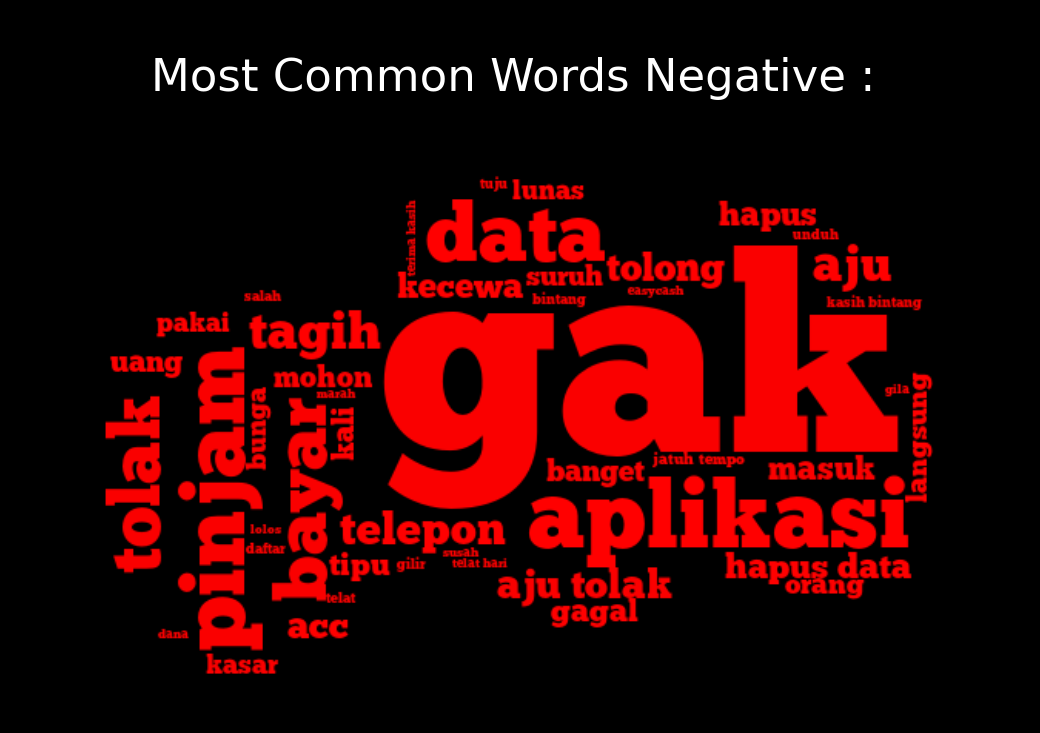


Kredit Pintar



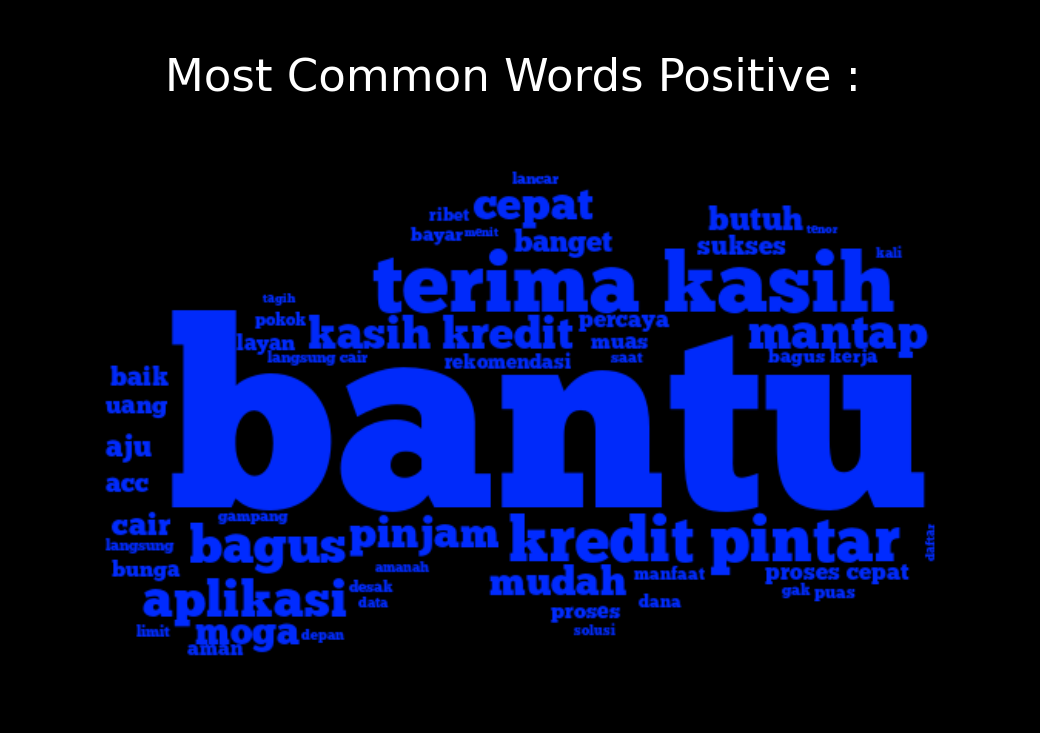

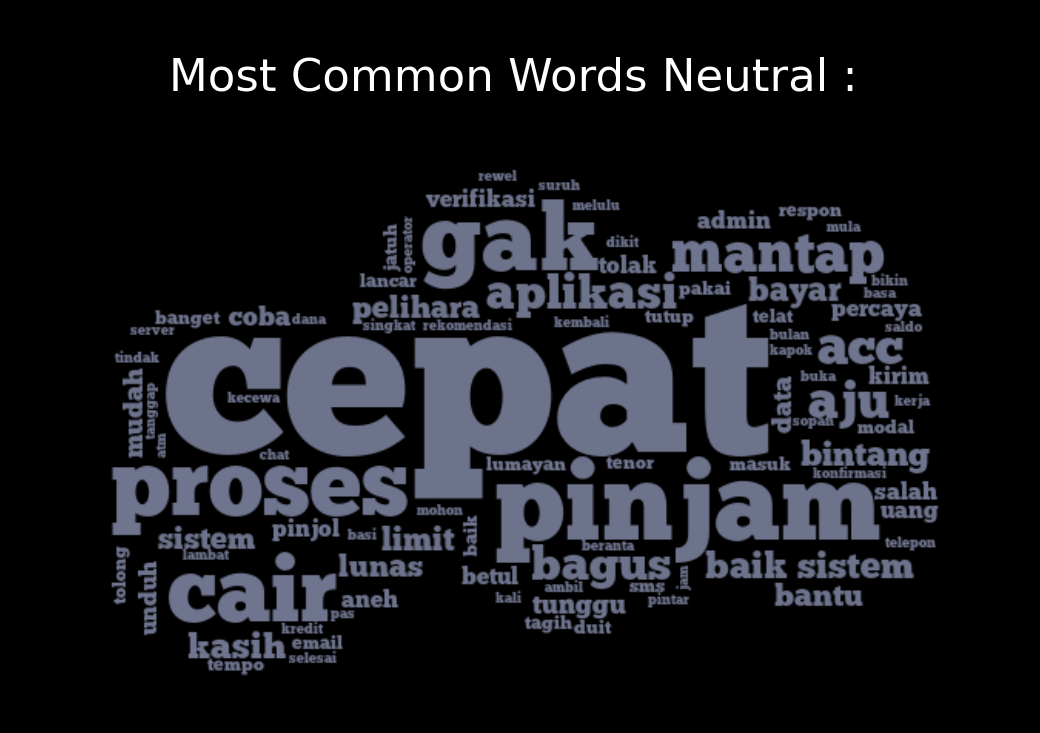

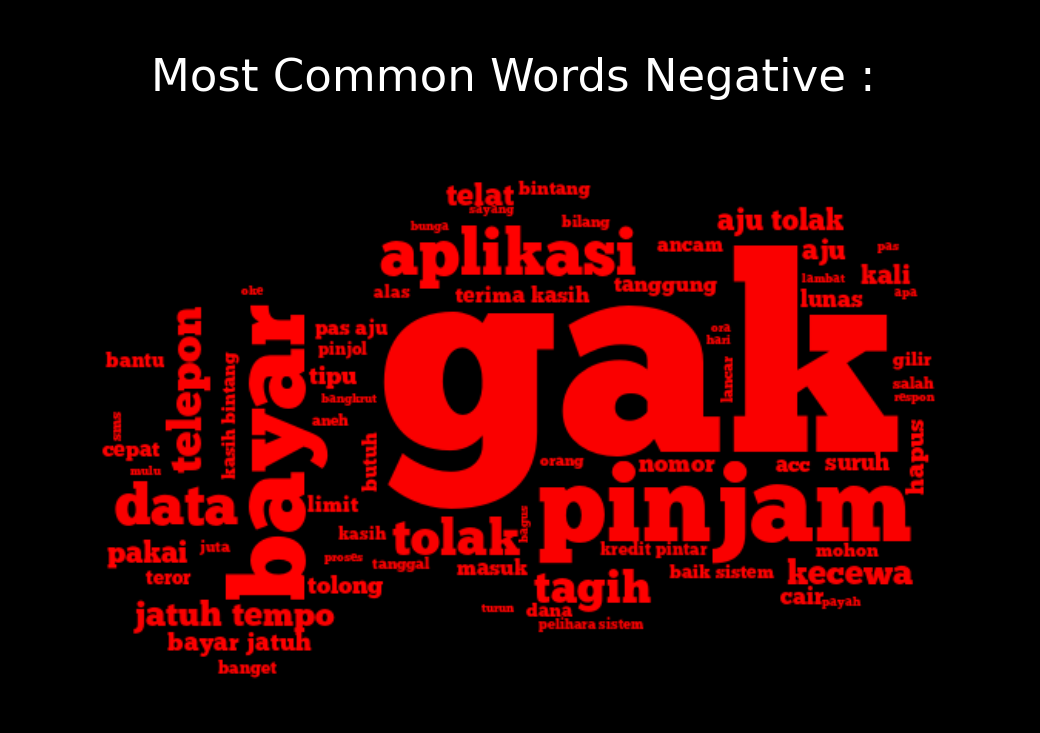

In [ ]:
for obj, name in zip(apps,objects):
    print('\n'+name+'\n')
    for i,j,k in zip(obj, sentm, custom_colors):
        wc = WordCloud(stopwords=STOPWORDS,font_path='assets/chunk.otf',
               mask=mask, background_color='black',
                       max_words=200, min_font_size=8, max_font_size=256,
                       random_state=42,width=mask.shape[1],
               height=mask.shape[0])
        # generate words
        wc.generate(i)
        plt.figure(figsize=(16,8), facecolor='k')
        plt.imshow(wc.recolor(color_func = k), interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.title('\nMost Common Words '+j+' : \n', size=45, color='white')
        plt.show()
    print('======================================================================'+
          '===================================================================')